### Deep Neural Network for SOC Prediction with using Panasonic 18650PF Li-ion Battery

Panasonic 18650PF Li-ion Battery DataSet - https://data.mendeley.com/datasets/wykht8y7tg/1

In [37]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
PROCESSED_DATA_DIR = '../../datasets/Panasonic_dataset/Panasonic_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Voltage Average', 'Current Average', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 1024
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [40]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [41]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [42]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [43]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [44]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,3.86277,-2.23754,0.754623,-0.02364,3.895890,-1.700817,0.000029,-0.023551,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.643102
1,2017-05-30 20:17:33,50.097998,3.84797,-2.27755,0.754623,-0.02371,3.895549,-1.699886,0.000027,-0.023613,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.763944
2,2017-05-30 20:17:33,50.198993,3.84025,-2.29470,0.754623,-0.02377,3.895338,-1.698867,0.000028,-0.023677,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.812222
3,2017-05-30 20:17:33,50.296991,3.83575,-2.30205,0.754623,-0.02384,3.895206,-1.697771,0.000027,-0.023740,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.830088
4,2017-05-30 20:17:33,50.398992,3.83317,-2.30613,0.754623,-0.02390,3.895125,-1.696615,0.000028,-0.023805,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.839788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953837,2017-06-14 08:01:15,586318.964002,3.80679,-0.07268,-9.940246,-0.89027,3.744033,-0.525554,0.000026,0.871713,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4953838,2017-06-14 08:01:15,586319.064997,3.80679,-0.07268,-9.940246,-0.89027,3.743971,-0.525556,0.000028,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,-0.276677
4953839,2017-06-14 08:01:15,586319.124995,3.80679,0.00000,-9.940246,-0.89028,3.743910,-0.525411,0.000017,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000
4953840,2017-06-14 08:01:15,586319.135999,3.80679,0.00000,-10.158136,-0.89028,3.743848,-0.525267,0.000003,0.871711,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.000000


In [45]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,0.946053,-0.686221,-0.468729,-0.02364,1.141736,-0.783969,0.000029,1.252216,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.861626
1,2017-05-30 20:17:33,50.097998,0.893321,-0.708138,-0.468729,-0.02371,1.140427,-0.782946,0.000027,1.252146,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.881194
2,2017-05-30 20:17:33,50.198993,0.865814,-0.717532,-0.468729,-0.02377,1.139616,-0.781827,0.000028,1.252074,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.889011
3,2017-05-30 20:17:33,50.296991,0.849781,-0.721558,-0.468729,-0.02384,1.139107,-0.780622,0.000027,1.252004,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.891905
4,2017-05-30 20:17:33,50.398992,0.840588,-0.723793,-0.468729,-0.02390,1.138796,-0.779352,0.000028,1.251930,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.893475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953837,2017-06-14 08:01:15,586318.964002,0.746596,0.499659,-1.233183,-0.89027,0.558446,0.507342,0.000026,2.255737,0.397199,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493145
4953838,2017-06-14 08:01:15,586319.064997,0.746596,0.499659,-1.233183,-0.89027,0.558208,0.507340,0.000028,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.493145
4953839,2017-06-14 08:01:15,586319.124995,0.746596,0.539472,-1.233183,-0.89028,0.557971,0.507500,0.000017,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.537948
4953840,2017-06-14 08:01:15,586319.135999,0.746596,0.539472,-1.248758,-0.89028,0.557734,0.507658,0.000003,2.255735,0.397198,06-07-17_08.39 n10degC_US06_HWFET_UDDS_LA92_Pa...,0.537948


In [46]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [47]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [48]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [49]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [50]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'03-27-17_09.06 10degC_LA92_Pan18650PF_processed.csv', '06-25-17_03.01 n20degC_Cycle_4_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_UDDS_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_NN_Pan18650PF_processed.csv', '06-02-17_10.43 0degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_NN_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_HWFET_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_UDDS_Pan18650PF_processed.csv', '03-20-17_05.56 25degC_HWFTa_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv', '06-01-17_10.36 0degC_LA92_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv', '03-18-17_02.17 25degC_Cycle_1_Pan18650PF_processed.csv', '03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv', '03-20-17_19.27 25degC_HWFTb_Pan18650PF_processed.csv', '06-10-17_18.35 n10degC_Cycle_2_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_HWFET_Pan18650PF_processed.csv', '03-21-17_00.29 25degC_UDDS_Pan

In [52]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([4060415, 7])
Test features shape: torch.Size([323914, 7])
Train labels shape: torch.Size([4060415])
Test labels shape: torch.Size([323914])


## Hyperparameter tuning

In [53]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [54]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-08-01 16:07:17,674] A new study created in memory with name: no-name-d49cecd8-8fdc-4a96-b46d-190748e26942
Epoch: 0/10: 100%|██████████| 3966/3966 [00:35<00:00, 111.00it/s]


Epoch 1/10, Train Loss: 0.005603162024876519, Validation Loss: 0.24424336501606198
Time taken for epoch: 35.73104835 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:39<00:00, 100.68it/s]


Epoch 2/10, Train Loss: 0.005310043215890665, Validation Loss: 0.17574314056253626
Time taken for epoch: 39.39447975 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:37<00:00, 104.51it/s]


Epoch 3/10, Train Loss: 0.005374123146372368, Validation Loss: 0.1459542752074259
Time taken for epoch: 37.95138168 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:37<00:00, 105.28it/s]


Epoch 4/10, Train Loss: 0.005385846661242214, Validation Loss: 0.3177164274105786
Time taken for epoch: 37.67201900 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:38<00:00, 103.49it/s]


Epoch 5/10, Train Loss: 0.005425592725208866, Validation Loss: 0.22473406582797795
Time taken for epoch: 38.32585192 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.49it/s] 


Epoch 6/10, Train Loss: 0.005426604709218374, Validation Loss: 0.21286068947979134
Time taken for epoch: 44.32192898 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.49it/s] 


Epoch 7/10, Train Loss: 0.0054370981961182506, Validation Loss: 0.1875345754845853
Time taken for epoch: 45.33167100 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.96it/s] 


Epoch 8/10, Train Loss: 0.005448511122423917, Validation Loss: 0.1755190809752329
Time taken for epoch: 43.60415697 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:46<00:00, 84.63it/s] 


Epoch 9/10, Train Loss: 0.005473512387235682, Validation Loss: 0.22920205542253713
Time taken for epoch: 46.86450815 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:44<00:00, 88.50it/s] 
[I 2025-08-01 16:14:48,630] Trial 0 finished with value: 0.2403613938409596 and parameters: {'learning_rate': 0.004848018920152454, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.21990705777762987}. Best is trial 0 with value: 0.2403613938409596.


Epoch 10/10, Train Loss: 0.005463978813057535, Validation Loss: 0.2403613938409596
Time taken for epoch: 44.81475806 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:37<00:00, 105.44it/s]


Epoch 1/10, Train Loss: 0.027852782084917968, Validation Loss: 0.17221550743123373
Time taken for epoch: 37.61630082 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:37<00:00, 104.90it/s]


Epoch 2/10, Train Loss: 0.024991155589357265, Validation Loss: 0.13520402439709372
Time taken for epoch: 37.81017709 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:38<00:00, 104.01it/s]


Epoch 3/10, Train Loss: 0.02494582507019159, Validation Loss: 0.16082151051189153
Time taken for epoch: 38.13485694 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:38<00:00, 103.20it/s]


Epoch 4/10, Train Loss: 0.025000486680716503, Validation Loss: 0.1534222990328271
Time taken for epoch: 38.43337893 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.75it/s]


Epoch 5/10, Train Loss: 0.024989258949759927, Validation Loss: 0.15869607755921752
Time taken for epoch: 38.59946322 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:38<00:00, 101.93it/s]


Epoch 6/10, Train Loss: 0.02499502588935155, Validation Loss: 0.15276785239566085
Time taken for epoch: 38.91047025 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.31it/s]


Epoch 7/10, Train Loss: 0.025004571689780288, Validation Loss: 0.16021161123866481
Time taken for epoch: 38.76531625 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.81it/s]


Epoch 8/10, Train Loss: 0.024975299181917283, Validation Loss: 0.1436154427999297
Time taken for epoch: 38.57808590 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:39<00:00, 101.23it/s]


Epoch 9/10, Train Loss: 0.02497619861456041, Validation Loss: 0.15382694568587185
Time taken for epoch: 39.18052602 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.16it/s]
[I 2025-08-01 16:21:51,303] Trial 1 finished with value: 0.14494547344686612 and parameters: {'learning_rate': 0.0041767144163863046, 'hidden_size': 16, 'num_layers': 3, 'dropout_rate': 0.28497335357062253}. Best is trial 1 with value: 0.14494547344686612.


Epoch 10/10, Train Loss: 0.02495881338405131, Validation Loss: 0.14494547344686612
Time taken for epoch: 38.82281208 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:35<00:00, 111.21it/s]


Epoch 1/10, Train Loss: 0.012027878202479173, Validation Loss: 0.08481212818437835
Time taken for epoch: 35.66333413 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:37<00:00, 106.53it/s]


Epoch 2/10, Train Loss: 0.011783939750092053, Validation Loss: 0.0706710523436691
Time taken for epoch: 37.23095107 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:35<00:00, 111.32it/s]


Epoch 3/10, Train Loss: 0.011756755637997818, Validation Loss: 0.067864863253319
Time taken for epoch: 35.62775183 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:35<00:00, 112.81it/s]


Epoch 4/10, Train Loss: 0.01172978770240495, Validation Loss: 0.10902377313947487
Time taken for epoch: 35.15739822 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:35<00:00, 110.31it/s]


Epoch 5/10, Train Loss: 0.01177258240866822, Validation Loss: 0.0974343922447036
Time taken for epoch: 35.95427203 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:36<00:00, 110.07it/s]


Epoch 6/10, Train Loss: 0.01178860696726791, Validation Loss: 0.08676818329465148
Time taken for epoch: 36.03429794 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:37<00:00, 105.33it/s]


Epoch 7/10, Train Loss: 0.011772539285098475, Validation Loss: 0.06797957927524106
Time taken for epoch: 37.65673184 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:35<00:00, 112.24it/s]


Epoch 8/10, Train Loss: 0.011789824946046598, Validation Loss: 0.11569847015500723
Time taken for epoch: 35.33812404 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:35<00:00, 112.79it/s]


Epoch 9/10, Train Loss: 0.011771619535251828, Validation Loss: 0.08540950483560929
Time taken for epoch: 35.16597581 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:35<00:00, 113.30it/s]
[I 2025-08-01 16:28:28,580] Trial 2 finished with value: 0.13731092401560785 and parameters: {'learning_rate': 0.01834930538355624, 'hidden_size': 16, 'num_layers': 1, 'dropout_rate': 0.38015525089108193}. Best is trial 2 with value: 0.13731092401560785.


Epoch 10/10, Train Loss: 0.01177991722676146, Validation Loss: 0.13731092401560785
Time taken for epoch: 35.00785589 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:40<00:00, 96.79it/s] 


Epoch 1/10, Train Loss: 0.14983006090064782, Validation Loss: 0.07458252536625763
Time taken for epoch: 40.97873521 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.76it/s] 


Epoch 2/10, Train Loss: 0.037270894469491354, Validation Loss: 0.08022579666057233
Time taken for epoch: 41.85425091 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.61it/s] 


Epoch 3/10, Train Loss: 0.021449235485151853, Validation Loss: 0.08788681705780135
Time taken for epoch: 41.92014384 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.77it/s] 


Epoch 4/10, Train Loss: 0.01291449114222848, Validation Loss: 0.10218880615833853
Time taken for epoch: 41.41267920 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.15it/s] 


Epoch 5/10, Train Loss: 0.008743350145975772, Validation Loss: 0.14701923481962553
Time taken for epoch: 41.68525410 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.16it/s] 


Epoch 6/10, Train Loss: 0.006496109398912246, Validation Loss: 0.22436682243830222
Time taken for epoch: 41.67897010 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.25it/s] 


Epoch 7/10, Train Loss: 0.005199845179429807, Validation Loss: 0.26451246593298633
Time taken for epoch: 42.53081918 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.92it/s] 


Epoch 8/10, Train Loss: 0.004380638067553264, Validation Loss: 0.33638200175969696
Time taken for epoch: 41.78560996 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.31it/s] 


Epoch 9/10, Train Loss: 0.00387576663101339, Validation Loss: 0.33536871142929925
Time taken for epoch: 41.61502314 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:42<00:00, 94.01it/s] 
[I 2025-08-01 16:36:07,036] Trial 3 finished with value: 0.3137630407899413 and parameters: {'learning_rate': 1.154215615629861e-05, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.14024679501899115}. Best is trial 2 with value: 0.13731092401560785.


Epoch 10/10, Train Loss: 0.0035684256074951038, Validation Loss: 0.3137630407899413
Time taken for epoch: 42.18908405 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:43<00:00, 92.03it/s] 


Epoch 1/10, Train Loss: 0.4216169016196219, Validation Loss: 0.06749278842766758
Time taken for epoch: 43.09443307 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.79it/s] 


Epoch 2/10, Train Loss: 0.14388356857336174, Validation Loss: 0.035880021508340076
Time taken for epoch: 43.68640494 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.25it/s] 


Epoch 3/10, Train Loss: 0.06990908479963326, Validation Loss: 0.03446206249440499
Time taken for epoch: 43.94663310 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.53it/s] 


Epoch 4/10, Train Loss: 0.04345975052687446, Validation Loss: 0.04810260799478564
Time taken for epoch: 43.33410692 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.09it/s] 


Epoch 5/10, Train Loss: 0.03295271125102187, Validation Loss: 0.0623598959515952
Time taken for epoch: 42.60408401 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.02it/s] 


Epoch 6/10, Train Loss: 0.02829215814562846, Validation Loss: 0.07172657675841514
Time taken for epoch: 42.63954806 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.13it/s] 


Epoch 7/10, Train Loss: 0.026113415817930672, Validation Loss: 0.08267510203120412
Time taken for epoch: 43.52100897 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.23it/s] 


Epoch 8/10, Train Loss: 0.02547851498358504, Validation Loss: 0.09646305801607095
Time taken for epoch: 44.44779205 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.58it/s] 


Epoch 9/10, Train Loss: 0.025326489622597134, Validation Loss: 0.10130571884457211
Time taken for epoch: 43.78892207 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:46<00:00, 85.98it/s] 
[I 2025-08-01 16:44:06,581] Trial 4 finished with value: 0.11222895695522787 and parameters: {'learning_rate': 2.1986589968282932e-05, 'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.49657739705764115}. Best is trial 4 with value: 0.11222895695522787.


Epoch 10/10, Train Loss: 0.02527406682183781, Validation Loss: 0.11222895695522787
Time taken for epoch: 46.13129210 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.70it/s]


Epoch 1/10, Train Loss: 0.017991051906311204, Validation Loss: 0.08870043104539926
Time taken for epoch: 49.76531315 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:47<00:00, 83.55it/s]


Epoch 2/10, Train Loss: 0.017906321199733878, Validation Loss: 0.028071269398998955
Time taken for epoch: 47.47175193 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:47<00:00, 83.73it/s]


Epoch 3/10, Train Loss: 0.01793853777089258, Validation Loss: 0.03209912354900659
Time taken for epoch: 47.36618209 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:47<00:00, 83.37it/s]


Epoch 4/10, Train Loss: 0.017922682688109842, Validation Loss: 0.08615729336298064
Time taken for epoch: 47.57276893 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:47<00:00, 84.15it/s]


Epoch 5/10, Train Loss: 0.017963971681535934, Validation Loss: 0.12352106934973968
Time taken for epoch: 47.12984109 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:47<00:00, 84.28it/s]


Epoch 6/10, Train Loss: 0.01820301298362983, Validation Loss: 0.07754130733049953
Time taken for epoch: 47.05689383 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:47<00:00, 83.77it/s]


Epoch 7/10, Train Loss: 0.018217010863136596, Validation Loss: 0.05364331395283107
Time taken for epoch: 47.34640098 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:46<00:00, 84.96it/s]


Epoch 8/10, Train Loss: 0.01816349443653152, Validation Loss: 0.03778300377388841
Time taken for epoch: 46.68401098 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:46<00:00, 84.81it/s]


Epoch 9/10, Train Loss: 0.018239985372771595, Validation Loss: 0.06522386522080705
Time taken for epoch: 46.76362872 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:46<00:00, 84.87it/s]
[I 2025-08-01 16:52:44,946] Trial 5 finished with value: 0.04770436805765271 and parameters: {'learning_rate': 0.04825169378710963, 'hidden_size': 64, 'num_layers': 3, 'dropout_rate': 0.3369067288009626}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.01857305365716508, Validation Loss: 0.04770436805765271
Time taken for epoch: 46.73362422 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.71it/s]


Epoch 1/10, Train Loss: 0.018193095843098677, Validation Loss: 0.1614979495064762
Time taken for epoch: 49.75705814 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.07it/s]


Epoch 2/10, Train Loss: 0.017272815975748975, Validation Loss: 0.15946838334099506
Time taken for epoch: 49.53429818 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.28it/s]


Epoch 3/10, Train Loss: 0.017326913574176022, Validation Loss: 0.13743058149598017
Time taken for epoch: 51.32138801 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:53<00:00, 73.88it/s]


Epoch 4/10, Train Loss: 0.017367329197196996, Validation Loss: 0.118698548977238
Time taken for epoch: 53.68107224 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:48<00:00, 82.40it/s]


Epoch 5/10, Train Loss: 0.017361065876527877, Validation Loss: 0.14989179384317974
Time taken for epoch: 48.13573623 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:48<00:00, 81.70it/s]


Epoch 6/10, Train Loss: 0.017442433562494187, Validation Loss: 0.2086286085626921
Time taken for epoch: 48.54605603 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:44<00:00, 89.49it/s] 


Epoch 7/10, Train Loss: 0.017475777352158314, Validation Loss: 0.12291607229791018
Time taken for epoch: 44.31923199 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.67it/s] 


Epoch 8/10, Train Loss: 0.017467373880861583, Validation Loss: 0.11161557845102761
Time taken for epoch: 42.80118132 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:43<00:00, 90.66it/s] 


Epoch 9/10, Train Loss: 0.01750239174938899, Validation Loss: 0.14007654853991866
Time taken for epoch: 43.75002003 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.94it/s] 
[I 2025-08-01 17:01:25,446] Trial 6 finished with value: 0.09761392939688537 and parameters: {'learning_rate': 0.005010298369022039, 'hidden_size': 64, 'num_layers': 4, 'dropout_rate': 0.3187749145234108}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.017515490793886507, Validation Loss: 0.09761392939688537
Time taken for epoch: 45.10272002 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:38<00:00, 104.23it/s]


Epoch 1/10, Train Loss: 0.009491353483722214, Validation Loss: 0.07057657351545081
Time taken for epoch: 38.05206704 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:37<00:00, 105.08it/s]


Epoch 2/10, Train Loss: 0.009747896535557837, Validation Loss: 0.04310750838329577
Time taken for epoch: 37.74548888 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:36<00:00, 107.30it/s]


Epoch 3/10, Train Loss: 0.009911934642376687, Validation Loss: 0.04909292877834055
Time taken for epoch: 36.96384192 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:37<00:00, 105.90it/s]


Epoch 4/10, Train Loss: 0.010105212782173823, Validation Loss: 0.13535357439618068
Time taken for epoch: 37.45302868 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:36<00:00, 108.20it/s]


Epoch 5/10, Train Loss: 0.010149888489752316, Validation Loss: 0.07665569227104714
Time taken for epoch: 36.65554690 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:36<00:00, 109.41it/s]


Epoch 6/10, Train Loss: 0.010030563859798792, Validation Loss: 0.09526538891061505
Time taken for epoch: 36.24986076 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:36<00:00, 108.38it/s]


Epoch 7/10, Train Loss: 0.010254057474735893, Validation Loss: 0.03668087891221779
Time taken for epoch: 36.59647799 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:37<00:00, 106.61it/s]


Epoch 8/10, Train Loss: 0.010236108605855576, Validation Loss: 0.054320328694472404
Time taken for epoch: 37.20141292 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:36<00:00, 108.56it/s]


Epoch 9/10, Train Loss: 0.010236389615534948, Validation Loss: 0.06671427222061986
Time taken for epoch: 36.53420496 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:36<00:00, 109.79it/s]
[I 2025-08-01 17:08:14,943] Trial 7 finished with value: 0.09166179652077433 and parameters: {'learning_rate': 0.048168567161476175, 'hidden_size': 64, 'num_layers': 1, 'dropout_rate': 0.3730890888378807}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.010379279088473161, Validation Loss: 0.09166179652077433
Time taken for epoch: 36.12558627 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.41it/s] 


Epoch 1/10, Train Loss: 0.037401933130487404, Validation Loss: 0.06424308451320974
Time taken for epoch: 43.38709092 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.26it/s] 


Epoch 2/10, Train Loss: 0.03681691577052204, Validation Loss: 0.08069460936195899
Time taken for epoch: 42.98949218 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.96it/s] 


Epoch 3/10, Train Loss: 0.035069798804590394, Validation Loss: 0.0707015133593291
Time taken for epoch: 42.21332502 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.99it/s] 


Epoch 4/10, Train Loss: 0.035069766908083756, Validation Loss: 0.08366945383831777
Time taken for epoch: 42.19978189 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:42<00:00, 94.08it/s] 


Epoch 5/10, Train Loss: 0.03510239066164405, Validation Loss: 0.07456175062733869
Time taken for epoch: 42.15834022 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.83it/s] 


Epoch 6/10, Train Loss: 0.03508182956057024, Validation Loss: 0.09139214044509239
Time taken for epoch: 42.27120900 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.90it/s] 


Epoch 7/10, Train Loss: 0.035098852008295614, Validation Loss: 0.06972894541503881
Time taken for epoch: 42.69473100 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.97it/s] 


Epoch 8/10, Train Loss: 0.035110551076300116, Validation Loss: 0.07759482452070718
Time taken for epoch: 42.66206002 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.91it/s] 


Epoch 9/10, Train Loss: 0.035398553343949084, Validation Loss: 0.07030234946910201
Time taken for epoch: 42.68747091 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.64it/s] 
[I 2025-08-01 17:16:02,430] Trial 8 finished with value: 0.06981609881363944 and parameters: {'learning_rate': 0.010879849584695673, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.24727669042627676}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.03572543798483235, Validation Loss: 0.06981609881363944
Time taken for epoch: 43.28084874 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:41<00:00, 95.78it/s] 


Epoch 1/10, Train Loss: 0.012188287379125728, Validation Loss: 0.5838443368050075
Time taken for epoch: 41.40790105 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:41<00:00, 94.93it/s] 


Epoch 2/10, Train Loss: 0.0022540886663508647, Validation Loss: 0.3947578520365975
Time taken for epoch: 41.77863622 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:41<00:00, 96.46it/s] 


Epoch 3/10, Train Loss: 0.0024127508764306906, Validation Loss: 0.2711851307850278
Time taken for epoch: 41.11623597 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:40<00:00, 96.94it/s] 


Epoch 4/10, Train Loss: 0.002421975876211714, Validation Loss: 0.2559669837669414
Time taken for epoch: 40.91419697 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:40<00:00, 98.27it/s] 


Epoch 5/10, Train Loss: 0.0024205039858414623, Validation Loss: 0.2561113653328793
Time taken for epoch: 40.35871482 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:39<00:00, 99.77it/s] 


Epoch 6/10, Train Loss: 0.002413169587941195, Validation Loss: 0.2567005750523689
Time taken for epoch: 39.75382495 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:40<00:00, 97.74it/s] 


Epoch 7/10, Train Loss: 0.002414666971857967, Validation Loss: 0.258243463030191
Time taken for epoch: 40.58086872 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:40<00:00, 97.90it/s] 


Epoch 8/10, Train Loss: 0.0024119494724159276, Validation Loss: 0.2490261194592941
Time taken for epoch: 40.51217484 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:40<00:00, 98.02it/s] 


Epoch 9/10, Train Loss: 0.002414089096796972, Validation Loss: 0.2597462053930502
Time taken for epoch: 40.46379781 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:40<00:00, 97.73it/s] 
[I 2025-08-01 17:23:30,694] Trial 9 finished with value: 0.2546378943774164 and parameters: {'learning_rate': 0.0001461086622664962, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.15438355185150382}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.002419952535502795, Validation Loss: 0.2546378943774164
Time taken for epoch: 40.58467102 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.52it/s]


Epoch 1/10, Train Loss: 0.029121848480307237, Validation Loss: 0.21833298351108296
Time taken for epoch: 38.68836784 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:39<00:00, 101.31it/s]


Epoch 2/10, Train Loss: 0.014357662226195084, Validation Loss: 0.2169655757211747
Time taken for epoch: 39.14901304 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:38<00:00, 101.84it/s]


Epoch 3/10, Train Loss: 0.014350209353455032, Validation Loss: 0.23970092386827063
Time taken for epoch: 38.94550109 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.29it/s]


Epoch 4/10, Train Loss: 0.014349860081893442, Validation Loss: 0.2142556713925406
Time taken for epoch: 38.77333784 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.17it/s]


Epoch 5/10, Train Loss: 0.014337270527437471, Validation Loss: 0.23259533081479702
Time taken for epoch: 38.82172298 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:38<00:00, 103.14it/s]


Epoch 6/10, Train Loss: 0.014364397673869052, Validation Loss: 0.22048961902302175
Time taken for epoch: 38.45450091 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.45it/s]


Epoch 7/10, Train Loss: 0.014351913650049083, Validation Loss: 0.2371554033073984
Time taken for epoch: 38.71320295 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.89it/s]


Epoch 8/10, Train Loss: 0.01436172268107774, Validation Loss: 0.1968739889542242
Time taken for epoch: 38.54819036 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:38<00:00, 103.13it/s]


Epoch 9/10, Train Loss: 0.014353436262892072, Validation Loss: 0.24476955873524764
Time taken for epoch: 38.45956898 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:38<00:00, 102.48it/s]
[I 2025-08-01 17:30:38,321] Trial 10 finished with value: 0.22379173640746913 and parameters: {'learning_rate': 0.0005826159570796061, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.47367244377663364}. Best is trial 5 with value: 0.04770436805765271.


Epoch 10/10, Train Loss: 0.014360690489411354, Validation Loss: 0.22379173640746913
Time taken for epoch: 38.70227003 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.42it/s] 


Epoch 1/10, Train Loss: 0.04103321103877902, Validation Loss: 0.06728944771891703
Time taken for epoch: 43.38547993 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.30it/s] 


Epoch 2/10, Train Loss: 0.040812136258777804, Validation Loss: 0.04491430849101851
Time taken for epoch: 43.44038606 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:43<00:00, 92.05it/s] 


Epoch 3/10, Train Loss: 0.04101191341042879, Validation Loss: 0.06861623669732404
Time taken for epoch: 43.08678722 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:42<00:00, 93.14it/s] 


Epoch 4/10, Train Loss: 0.04087203695705096, Validation Loss: 0.03430777228902346
Time taken for epoch: 42.58231282 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.51it/s] 


Epoch 5/10, Train Loss: 0.04111623642867524, Validation Loss: 0.0879400844249362
Time taken for epoch: 42.87429786 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.47it/s] 


Epoch 6/10, Train Loss: 0.040990162780766705, Validation Loss: 0.04264837644431685
Time taken for epoch: 43.36109424 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:43<00:00, 92.02it/s] 


Epoch 7/10, Train Loss: 0.04097634638165111, Validation Loss: 0.05972211221599486
Time taken for epoch: 43.10235596 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.74it/s] 


Epoch 8/10, Train Loss: 0.04104481846943265, Validation Loss: 0.05069671187314726
Time taken for epoch: 42.76865792 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:43<00:00, 91.53it/s] 


Epoch 9/10, Train Loss: 0.041068180414894524, Validation Loss: 0.05905716152973545
Time taken for epoch: 43.33322597 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:42<00:00, 92.37it/s] 
[I 2025-08-01 17:38:30,750] Trial 11 finished with value: 0.04422341201502988 and parameters: {'learning_rate': 0.09624757561667188, 'hidden_size': 16, 'num_layers': 4, 'dropout_rate': 0.2526010979269914}. Best is trial 11 with value: 0.04422341201502988.


Epoch 10/10, Train Loss: 0.04086842093254152, Validation Loss: 0.04422341201502988
Time taken for epoch: 42.93941593 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.60it/s]


Epoch 1/10, Train Loss: 0.027973854160044328, Validation Loss: 0.061993186610737376
Time taken for epoch: 51.10703397 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 77.99it/s]


Epoch 2/10, Train Loss: 0.028310901963960265, Validation Loss: 0.03721118452342984
Time taken for epoch: 50.85460997 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.14it/s]


Epoch 3/10, Train Loss: 0.02889903781130587, Validation Loss: 0.131609876263202
Time taken for epoch: 50.75508022 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.76it/s]


Epoch 4/10, Train Loss: 0.028719222851743827, Validation Loss: 0.2912299138551521
Time taken for epoch: 50.35823894 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.00it/s]


Epoch 5/10, Train Loss: 0.028681269259320265, Validation Loss: 0.049838883698916044
Time taken for epoch: 50.20527411 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.48it/s]


Epoch 6/10, Train Loss: 0.02887784375513721, Validation Loss: 0.07295296344434408
Time taken for epoch: 50.54025698 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.79it/s]


Epoch 7/10, Train Loss: 0.028714749261838316, Validation Loss: 0.03726967672963621
Time taken for epoch: 50.33766508 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.69it/s]


Epoch 8/10, Train Loss: 0.028701296739329068, Validation Loss: 0.03561450486531073
Time taken for epoch: 50.40013576 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.36it/s]


Epoch 9/10, Train Loss: 0.028330937233639376, Validation Loss: 0.05209713916561265
Time taken for epoch: 49.97916293 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.01it/s]
[I 2025-08-01 17:47:40,277] Trial 12 finished with value: 0.0333139309859983 and parameters: {'learning_rate': 0.09169063844501016, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.35129304483985335}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.028609216517561684, Validation Loss: 0.0333139309859983
Time taken for epoch: 50.84060407 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.58it/s]


Epoch 1/10, Train Loss: 0.030843031100940055, Validation Loss: 0.04055828292839448
Time taken for epoch: 49.83873296 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.87it/s]


Epoch 2/10, Train Loss: 0.031368379340240796, Validation Loss: 0.04454147009303563
Time taken for epoch: 50.28803134 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.16it/s]


Epoch 3/10, Train Loss: 0.03190421792234713, Validation Loss: 0.10097842547198733
Time taken for epoch: 50.74694777 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.40it/s]


Epoch 4/10, Train Loss: 0.03176031817423308, Validation Loss: 0.055468266890596654
Time taken for epoch: 51.24615717 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.79it/s]


Epoch 5/10, Train Loss: 0.0324225121516353, Validation Loss: 0.09382397044215751
Time taken for epoch: 50.33694100 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:51<00:00, 76.37it/s]


Epoch 6/10, Train Loss: 0.032191135203893204, Validation Loss: 0.04607288503784877
Time taken for epoch: 51.93256783 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:51<00:00, 76.54it/s]


Epoch 7/10, Train Loss: 0.03260264830242052, Validation Loss: 0.11717446039309731
Time taken for epoch: 51.82120180 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.23it/s]


Epoch 8/10, Train Loss: 0.0320964794806982, Validation Loss: 0.08599578292446405
Time taken for epoch: 50.69629121 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.06it/s]


Epoch 9/10, Train Loss: 0.03204913251806451, Validation Loss: 0.0582010082481301
Time taken for epoch: 51.46572304 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:54<00:00, 73.27it/s]
[I 2025-08-01 17:56:57,467] Trial 13 finished with value: 0.042085808683342475 and parameters: {'learning_rate': 0.09595781606027903, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.4147446048475012}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.032667554623766255, Validation Loss: 0.042085808683342475
Time taken for epoch: 54.13175607 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.65it/s]


Epoch 1/10, Train Loss: 0.05161334325188881, Validation Loss: 0.15403900960993508
Time taken for epoch: 51.07580805 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.37it/s]


Epoch 2/10, Train Loss: 0.01160304910309361, Validation Loss: 0.16819390456867842
Time taken for epoch: 50.60506105 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.35it/s]


Epoch 3/10, Train Loss: 0.011578433509386298, Validation Loss: 0.16979968324761102
Time taken for epoch: 50.62458777 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.35it/s]


Epoch 4/10, Train Loss: 0.011582369176906675, Validation Loss: 0.1743305501082804
Time taken for epoch: 50.62289214 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.72it/s]


Epoch 5/10, Train Loss: 0.011597066944154131, Validation Loss: 0.17511904888586358
Time taken for epoch: 50.38581300 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.82it/s]


Epoch 6/10, Train Loss: 0.011596983921654482, Validation Loss: 0.16895300260015772
Time taken for epoch: 49.68854690 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:49<00:00, 80.03it/s]


Epoch 7/10, Train Loss: 0.011592779257130469, Validation Loss: 0.17026319911765084
Time taken for epoch: 49.56124592 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.46it/s]


Epoch 8/10, Train Loss: 0.011609827370941263, Validation Loss: 0.15354874033224303
Time taken for epoch: 49.91114616 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.85it/s]


Epoch 9/10, Train Loss: 0.011597899236094979, Validation Loss: 0.1673232536250814
Time taken for epoch: 49.66886091 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.88it/s]
[I 2025-08-01 18:06:02,632] Trial 14 finished with value: 0.17113738551272373 and parameters: {'learning_rate': 0.0006663242638275359, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.420456495700983}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.011571522097869302, Validation Loss: 0.17113738551272373
Time taken for epoch: 49.65274119 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.01it/s]


Epoch 1/10, Train Loss: 0.030687680081908173, Validation Loss: 0.04753085287513347
Time taken for epoch: 50.19627786 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.92it/s]


Epoch 2/10, Train Loss: 0.03110557307775235, Validation Loss: 0.08159134677053564
Time taken for epoch: 50.25541210 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.97it/s]


Epoch 3/10, Train Loss: 0.03128965002490725, Validation Loss: 0.03913122435168094
Time taken for epoch: 50.22129202 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.21it/s]


Epoch 4/10, Train Loss: 0.03153909066625304, Validation Loss: 0.045731352664029265
Time taken for epoch: 50.71480298 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.77it/s]


Epoch 5/10, Train Loss: 0.03205609580420194, Validation Loss: 0.039292253517863106
Time taken for epoch: 50.34897900 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.40it/s]


Epoch 6/10, Train Loss: 0.03207420674070483, Validation Loss: 0.07411986192302943
Time taken for epoch: 49.94974303 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.23it/s]


Epoch 7/10, Train Loss: 0.03161026914737859, Validation Loss: 0.09803715157391557
Time taken for epoch: 50.05730295 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.50it/s]


Epoch 8/10, Train Loss: 0.031701836861816546, Validation Loss: 0.04859727492781936
Time taken for epoch: 49.88863111 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.36it/s]


Epoch 9/10, Train Loss: 0.03180162714295506, Validation Loss: 0.06960728504475988
Time taken for epoch: 49.97602797 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.26it/s]
[I 2025-08-01 18:15:08,486] Trial 15 finished with value: 0.048188779361434904 and parameters: {'learning_rate': 0.08726288305491689, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.4373544487623281}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.031887743003531144, Validation Loss: 0.048188779361434904
Time taken for epoch: 50.68092299 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.75it/s]


Epoch 1/10, Train Loss: 0.0190514638013499, Validation Loss: 0.057139671396229656
Time taken for epoch: 50.36674786 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.03it/s]


Epoch 2/10, Train Loss: 0.019567307224520682, Validation Loss: 0.07236513603249846
Time taken for epoch: 50.18405199 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 77.95it/s]


Epoch 3/10, Train Loss: 0.0191966641318115, Validation Loss: 0.06153682335659094
Time taken for epoch: 50.87991405 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.25it/s]


Epoch 4/10, Train Loss: 0.019552635405150648, Validation Loss: 0.07332407289304259
Time taken for epoch: 50.68723202 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.10it/s]


Epoch 5/10, Train Loss: 0.020088311242981355, Validation Loss: 0.03974814927836636
Time taken for epoch: 50.78610301 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.62it/s]


Epoch 6/10, Train Loss: 0.020235914163069777, Validation Loss: 0.07799810239078493
Time taken for epoch: 50.44605684 seconds


Epoch: 6/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.54it/s]


Epoch 7/10, Train Loss: 0.02056510701721071, Validation Loss: 0.05682543658670477
Time taken for epoch: 50.49735093 seconds


Epoch: 7/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.52it/s]


Epoch 8/10, Train Loss: 0.0203868500123752, Validation Loss: 0.05663928510362155
Time taken for epoch: 50.50846004 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.50it/s]


Epoch 9/10, Train Loss: 0.020615022027403854, Validation Loss: 0.05349806737940787
Time taken for epoch: 50.52644205 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.38it/s]
[I 2025-08-01 18:24:18,219] Trial 16 finished with value: 0.06755202146577464 and parameters: {'learning_rate': 0.020868251147202973, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.38526690320294454}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.020273642993024425, Validation Loss: 0.06755202146577464
Time taken for epoch: 50.60048389 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.70it/s] 


Epoch 1/10, Train Loss: 0.007303045657043032, Validation Loss: 0.265898169105238
Time taken for epoch: 45.22237802 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.00it/s] 


Epoch 2/10, Train Loss: 0.005524740300544707, Validation Loss: 0.32734887770736726
Time taken for epoch: 45.58882999 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:45<00:00, 86.83it/s] 


Epoch 3/10, Train Loss: 0.005549371234069433, Validation Loss: 0.272535986455761
Time taken for epoch: 45.67925286 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.98it/s] 


Epoch 4/10, Train Loss: 0.005556424303601186, Validation Loss: 0.2963980383466972
Time taken for epoch: 45.08250284 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.19it/s] 


Epoch 5/10, Train Loss: 0.005558580671123826, Validation Loss: 0.273668199228448
Time taken for epoch: 45.49016500 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:44<00:00, 88.20it/s] 


Epoch 6/10, Train Loss: 0.005554061307159942, Validation Loss: 0.35337854417201053
Time taken for epoch: 44.96824312 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:44<00:00, 88.15it/s] 


Epoch 7/10, Train Loss: 0.00555918287977565, Validation Loss: 0.3420524969104276
Time taken for epoch: 44.99196386 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.92it/s] 


Epoch 8/10, Train Loss: 0.005554733533962652, Validation Loss: 0.25076947828896456
Time taken for epoch: 45.10985804 seconds


Epoch: 8/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.23it/s] 


Epoch 9/10, Train Loss: 0.005556608172766658, Validation Loss: 0.3024602125126735
Time taken for epoch: 45.46998024 seconds


Epoch: 9/10: 100%|██████████| 3966/3966 [00:45<00:00, 87.99it/s] 
[I 2025-08-01 18:32:33,776] Trial 17 finished with value: 0.28323906007957234 and parameters: {'learning_rate': 0.001941124348188825, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4310207660554768}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.005565293402957251, Validation Loss: 0.28323906007957234
Time taken for epoch: 45.07780504 seconds


Epoch: 0/10: 100%|██████████| 3966/3966 [01:01<00:00, 64.66it/s]


Epoch 1/10, Train Loss: 0.033796771222127174, Validation Loss: 0.1977464602873469
Time taken for epoch: 61.33912897 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.71it/s]


Epoch 2/10, Train Loss: 0.004364531444253206, Validation Loss: 0.26920538226464563
Time taken for epoch: 60.35767984 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [01:00<00:00, 65.83it/s]


Epoch 3/10, Train Loss: 0.0035387460056427477, Validation Loss: 0.22016471314497707
Time taken for epoch: 60.25123310 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.14it/s]


Epoch 4/10, Train Loss: 0.003654171443232948, Validation Loss: 0.20178646792309904
Time taken for epoch: 59.96209311 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.55it/s]


Epoch 5/10, Train Loss: 0.0036604795370117557, Validation Loss: 0.22159133080964905
Time taken for epoch: 59.59452391 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.68it/s]


Epoch 6/10, Train Loss: 0.0036539987110158507, Validation Loss: 0.22064090210449747
Time taken for epoch: 59.47679996 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.91it/s]


Epoch 7/10, Train Loss: 0.0036549874991991015, Validation Loss: 0.20227250942285208
Time taken for epoch: 59.27930784 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.64it/s]


Epoch 8/10, Train Loss: 0.0036534222815184847, Validation Loss: 0.21573355673119957
Time taken for epoch: 59.51178217 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.75it/s]


Epoch 9/10, Train Loss: 0.0036459035576855182, Validation Loss: 0.22416867468187446
Time taken for epoch: 59.41869402 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:59<00:00, 66.75it/s]
[I 2025-08-01 18:43:20,728] Trial 18 finished with value: 0.21799040352725307 and parameters: {'learning_rate': 0.00014813089958988564, 'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.34532972057107786}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.0036487111859225523, Validation Loss: 0.21799040352725307
Time taken for epoch: 59.42075515 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.50it/s]


Epoch 1/10, Train Loss: 0.017046121059927716, Validation Loss: 0.04593622437719131
Time taken for epoch: 49.88826275 seconds


Epoch: 1/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.66it/s]


Epoch 2/10, Train Loss: 0.01770220048146992, Validation Loss: 0.053872259965810604
Time taken for epoch: 50.42214513 seconds


Epoch: 2/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.70it/s]


Epoch 3/10, Train Loss: 0.01794575216799065, Validation Loss: 0.046801616255933834
Time taken for epoch: 50.39593220 seconds


Epoch: 3/10: 100%|██████████| 3966/3966 [00:50<00:00, 79.13it/s]


Epoch 4/10, Train Loss: 0.017678787620184898, Validation Loss: 0.0635315544583084
Time taken for epoch: 50.12137794 seconds


Epoch: 4/10: 100%|██████████| 3966/3966 [00:51<00:00, 77.57it/s]


Epoch 5/10, Train Loss: 0.0180655050495817, Validation Loss: 0.11320549672301523
Time taken for epoch: 51.12801170 seconds


Epoch: 5/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.48it/s]


Epoch 6/10, Train Loss: 0.018614209021769926, Validation Loss: 0.05318396477835986
Time taken for epoch: 50.53512931 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 3966/3966 [00:49<00:00, 79.36it/s]


Epoch 7/10, Train Loss: 0.01887831946180225, Validation Loss: 0.0756462111311124
Time taken for epoch: 49.97505879 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.65it/s]


Epoch 8/10, Train Loss: 0.019247550896565706, Validation Loss: 0.0568587186256129
Time taken for epoch: 50.43091679 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 3966/3966 [00:50<00:00, 77.82it/s]


Epoch 9/10, Train Loss: 0.019936373377001864, Validation Loss: 0.10105774589948975
Time taken for epoch: 50.96515989 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 3966/3966 [00:50<00:00, 78.00it/s]
[I 2025-08-01 18:52:29,824] Trial 19 finished with value: 0.08817359363423832 and parameters: {'learning_rate': 0.02866404229019713, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.29233078618448693}. Best is trial 12 with value: 0.0333139309859983.


Epoch 10/10, Train Loss: 0.01956097166365331, Validation Loss: 0.08817359363423832
Time taken for epoch: 50.84513998 seconds
Early stopping triggered
Best hyperparameters: {'learning_rate': 0.09169063844501016, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.35129304483985335}


### Best hyperparameters: {'learning_rate': 0.09169063844501016, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.35129304483985335}

### Training and Validation

In [55]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.35129304483985335, inplace=False)
)
Trainable parameters: 12385


Epoch: 0/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.10it/s]


Epoch 1/50, Train Loss: 0.027675784114547228, Validation Loss: 0.035935999379346786
Time taken for epoch: 51.44485211 seconds


Epoch: 1/50: 100%|██████████| 3966/3966 [00:51<00:00, 76.94it/s]


Epoch 2/50, Train Loss: 0.029188012858299493, Validation Loss: 0.12985684538388223
Time taken for epoch: 51.54849601 seconds


Epoch: 2/50: 100%|██████████| 3966/3966 [00:51<00:00, 76.72it/s]


Epoch 3/50, Train Loss: 0.0294537682544611, Validation Loss: 0.05630683509200934
Time taken for epoch: 51.69894505 seconds


Epoch: 3/50: 100%|██████████| 3966/3966 [00:51<00:00, 76.27it/s]


Epoch 4/50, Train Loss: 0.029558626040196365, Validation Loss: 0.032622862244527824
Time taken for epoch: 51.99968982 seconds


Epoch: 4/50: 100%|██████████| 3966/3966 [00:52<00:00, 75.63it/s]


Epoch 5/50, Train Loss: 0.029945634941387765, Validation Loss: 0.048077946343882474
Time taken for epoch: 52.43995786 seconds


Epoch: 5/50: 100%|██████████| 3966/3966 [00:51<00:00, 76.99it/s]


Epoch 6/50, Train Loss: 0.029711217645309637, Validation Loss: 0.0643590193686909
Time taken for epoch: 51.51522708 seconds


Epoch: 6/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.35it/s]


Epoch 7/50, Train Loss: 0.029274073331717793, Validation Loss: 0.06174475309251213
Time taken for epoch: 51.27875495 seconds


Epoch: 7/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.05it/s]


Epoch 8/50, Train Loss: 0.029448733460749874, Validation Loss: 0.03754715435660168
Time taken for epoch: 51.47355294 seconds


Epoch: 8/50: 100%|██████████| 3966/3966 [00:51<00:00, 76.71it/s]


Epoch 9/50, Train Loss: 0.02955488385271001, Validation Loss: 0.06498909639096441
Time taken for epoch: 51.70070720 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 3966/3966 [00:50<00:00, 78.49it/s]


Epoch 10/50, Train Loss: 0.029177584776497976, Validation Loss: 0.07417188654934904
Time taken for epoch: 50.52864480 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 3966/3966 [00:50<00:00, 78.68it/s]


Epoch 11/50, Train Loss: 0.02907951648637795, Validation Loss: 0.08851000385632163
Time taken for epoch: 50.40989995 seconds
Early stopping triggered


Epoch: 11/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.63it/s]


Epoch 12/50, Train Loss: 0.028820541731457157, Validation Loss: 0.17800747302994482
Time taken for epoch: 51.09394169 seconds
Early stopping triggered


Epoch: 12/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.49it/s]


Epoch 13/50, Train Loss: 0.029190609843079873, Validation Loss: 0.08880578740107671
Time taken for epoch: 51.18252110 seconds
Early stopping triggered


Epoch: 13/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.75it/s]


Epoch 14/50, Train Loss: 0.029713417502966452, Validation Loss: 0.0407217350763223
Time taken for epoch: 51.01437902 seconds
Early stopping triggered


Epoch: 14/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.21it/s]


Epoch 15/50, Train Loss: 0.02994635920319753, Validation Loss: 0.0411969269018163
Time taken for epoch: 51.37005091 seconds
Early stopping triggered


Epoch: 15/50: 100%|██████████| 3966/3966 [00:50<00:00, 77.77it/s]


Epoch 16/50, Train Loss: 0.02997980815458496, Validation Loss: 0.06794243800836242
Time taken for epoch: 51.00031686 seconds
Early stopping triggered


Epoch: 16/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.72it/s]


Epoch 17/50, Train Loss: 0.029810540149842198, Validation Loss: 0.07477427033712307
Time taken for epoch: 51.02842402 seconds
Early stopping triggered


Epoch: 17/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.57it/s]


Epoch 18/50, Train Loss: 0.030136997663555456, Validation Loss: 0.06317270736275192
Time taken for epoch: 51.12911320 seconds
Early stopping triggered


Epoch: 18/50: 100%|██████████| 3966/3966 [00:51<00:00, 77.02it/s]


Epoch 19/50, Train Loss: 0.029930813460640394, Validation Loss: 0.0927855668995163
Time taken for epoch: 51.49684787 seconds
Early stopping triggered


Epoch: 19/50: 100%|██████████| 3966/3966 [00:50<00:00, 78.19it/s]


Epoch 20/50, Train Loss: 0.029921531092058033, Validation Loss: 0.04273233305268323
Time taken for epoch: 50.72510982 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 3966/3966 [00:50<00:00, 78.45it/s]


Epoch 21/50, Train Loss: 0.029766709853266144, Validation Loss: 0.05637378108158814
Time taken for epoch: 50.55673814 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 3966/3966 [01:11<00:00, 55.81it/s]


Epoch 22/50, Train Loss: 0.029827573641935532, Validation Loss: 0.07696024527526943
Time taken for epoch: 71.06657505 seconds
Early stopping triggered


Epoch: 22/50: 100%|██████████| 3966/3966 [02:00<00:00, 33.03it/s]


Epoch 23/50, Train Loss: 0.029786688268590444, Validation Loss: 0.1764236912358079
Time taken for epoch: 120.07690597 seconds
Early stopping triggered


Epoch: 23/50: 100%|██████████| 3966/3966 [01:59<00:00, 33.21it/s]


Epoch 24/50, Train Loss: 0.030751538431939757, Validation Loss: 0.04619246726291638
Time taken for epoch: 119.44075584 seconds
Early stopping triggered


Epoch: 24/50: 100%|██████████| 3966/3966 [01:59<00:00, 33.10it/s]


Epoch 25/50, Train Loss: 0.03109932890790268, Validation Loss: 0.07264283014061364
Time taken for epoch: 119.83279276 seconds
Early stopping triggered


Epoch: 25/50: 100%|██████████| 3966/3966 [02:00<00:00, 32.82it/s]


Epoch 26/50, Train Loss: 0.031088266452183582, Validation Loss: 0.03899163971951465
Time taken for epoch: 120.86235166 seconds
Early stopping triggered


Epoch: 26/50: 100%|██████████| 3966/3966 [01:59<00:00, 33.28it/s]


Epoch 27/50, Train Loss: 0.031002860506916672, Validation Loss: 0.04087738521381622
Time taken for epoch: 119.17638993 seconds
Early stopping triggered


Epoch: 27/50: 100%|██████████| 3966/3966 [02:04<00:00, 31.91it/s]


Epoch 28/50, Train Loss: 0.03096089755671979, Validation Loss: 0.06371244067879449
Time taken for epoch: 124.30208802 seconds
Early stopping triggered


Epoch: 28/50: 100%|██████████| 3966/3966 [01:58<00:00, 33.35it/s]


Epoch 29/50, Train Loss: 0.03115449460769054, Validation Loss: 0.06891674908820442
Time taken for epoch: 118.94202900 seconds
Early stopping triggered


Epoch: 29/50: 100%|██████████| 3966/3966 [01:59<00:00, 33.23it/s]


Epoch 30/50, Train Loss: 0.030780694855586543, Validation Loss: 0.06142522839839606
Time taken for epoch: 119.36012697 seconds
Early stopping triggered


Epoch: 30/50: 100%|██████████| 3966/3966 [02:15<00:00, 29.38it/s]


Epoch 31/50, Train Loss: 0.030797888875191734, Validation Loss: 0.06910534532874162
Time taken for epoch: 135.02372217 seconds
Early stopping triggered


Epoch: 31/50: 100%|██████████| 3966/3966 [02:18<00:00, 28.69it/s]


Epoch 32/50, Train Loss: 0.03192113220562057, Validation Loss: 0.0582098379486467
Time taken for epoch: 138.26040888 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.13it/s]


Epoch 33/50, Train Loss: 0.03066638883285927, Validation Loss: 0.04043556421385028
Time taken for epoch: 127.40073586 seconds
Early stopping triggered


Epoch: 33/50: 100%|██████████| 3966/3966 [02:07<00:00, 31.20it/s]


Epoch 34/50, Train Loss: 0.030930925213247612, Validation Loss: 0.047960656222738055
Time taken for epoch: 127.11672211 seconds
Early stopping triggered


Epoch: 34/50: 100%|██████████| 3966/3966 [00:52<00:00, 75.47it/s] 


Epoch 35/50, Train Loss: 0.03053663990709722, Validation Loss: 0.08122091931600774
Time taken for epoch: 52.55765486 seconds
Early stopping triggered


Epoch: 35/50: 100%|██████████| 3966/3966 [00:36<00:00, 107.61it/s]


Epoch 36/50, Train Loss: 0.02976598501425242, Validation Loss: 0.10907937481784541
Time taken for epoch: 36.85580492 seconds
Early stopping triggered


Epoch: 36/50: 100%|██████████| 3966/3966 [00:37<00:00, 105.53it/s]


Epoch 37/50, Train Loss: 0.029977671205584172, Validation Loss: 0.06267122920870137
Time taken for epoch: 37.58401275 seconds
Early stopping triggered


Epoch: 37/50: 100%|██████████| 3966/3966 [00:37<00:00, 105.17it/s]


Epoch 38/50, Train Loss: 0.029918375791370327, Validation Loss: 0.04256368514187845
Time taken for epoch: 37.71188402 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 3966/3966 [00:38<00:00, 103.79it/s]


Epoch 39/50, Train Loss: 0.029934382172272293, Validation Loss: 0.2698674696044916
Time taken for epoch: 38.21297407 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 3966/3966 [00:38<00:00, 102.18it/s]


Epoch 40/50, Train Loss: 0.02991976574029486, Validation Loss: 0.05144470023315635
Time taken for epoch: 38.81673980 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 3966/3966 [00:41<00:00, 94.81it/s] 


Epoch 41/50, Train Loss: 0.029743055287002766, Validation Loss: 0.058379077818348384
Time taken for epoch: 41.83366084 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 3966/3966 [00:45<00:00, 86.69it/s]


Epoch 42/50, Train Loss: 0.029706294100263837, Validation Loss: 0.21975923371160067
Time taken for epoch: 45.74895501 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 3966/3966 [00:44<00:00, 88.51it/s] 


Epoch 43/50, Train Loss: 0.029697100995404367, Validation Loss: 0.07296154084229144
Time taken for epoch: 44.80878091 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 3966/3966 [00:44<00:00, 89.55it/s] 


Epoch 44/50, Train Loss: 0.030104966912149964, Validation Loss: 0.05106594431800892
Time taken for epoch: 44.29156303 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 3966/3966 [00:44<00:00, 88.28it/s] 


Epoch 45/50, Train Loss: 0.029698384987717315, Validation Loss: 0.10025105332864445
Time taken for epoch: 44.92642426 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 3966/3966 [00:45<00:00, 87.50it/s] 


Epoch 46/50, Train Loss: 0.029992278943338963, Validation Loss: 0.0358544931116199
Time taken for epoch: 45.32798386 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 3966/3966 [00:45<00:00, 86.40it/s]


Epoch 47/50, Train Loss: 0.030026375108027, Validation Loss: 0.03793095192502038
Time taken for epoch: 45.90616822 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 3966/3966 [00:46<00:00, 85.59it/s]


Epoch 48/50, Train Loss: 0.029744027752618987, Validation Loss: 0.13535822839445077
Time taken for epoch: 46.33826995 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 3966/3966 [00:46<00:00, 84.96it/s]


Epoch 49/50, Train Loss: 0.029711358200343523, Validation Loss: 0.20120154997707532
Time taken for epoch: 46.68544579 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 3966/3966 [00:48<00:00, 81.90it/s]


Epoch 50/50, Train Loss: 0.029543080979575878, Validation Loss: 0.03977446471065212
Time taken for epoch: 48.42528272 seconds
Early stopping triggered


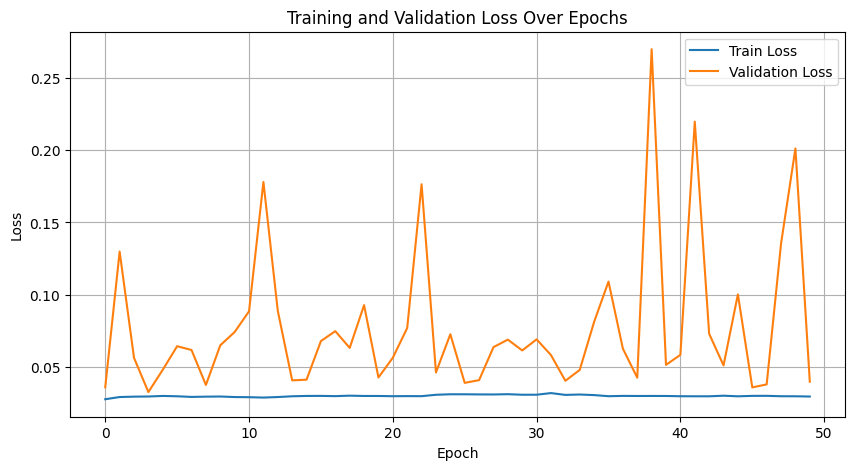

In [56]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_dnn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [57]:
model_path = "soc_dnn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [58]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [59]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.014546
Test MAE: 0.097330
Test StdDev: 0.120280


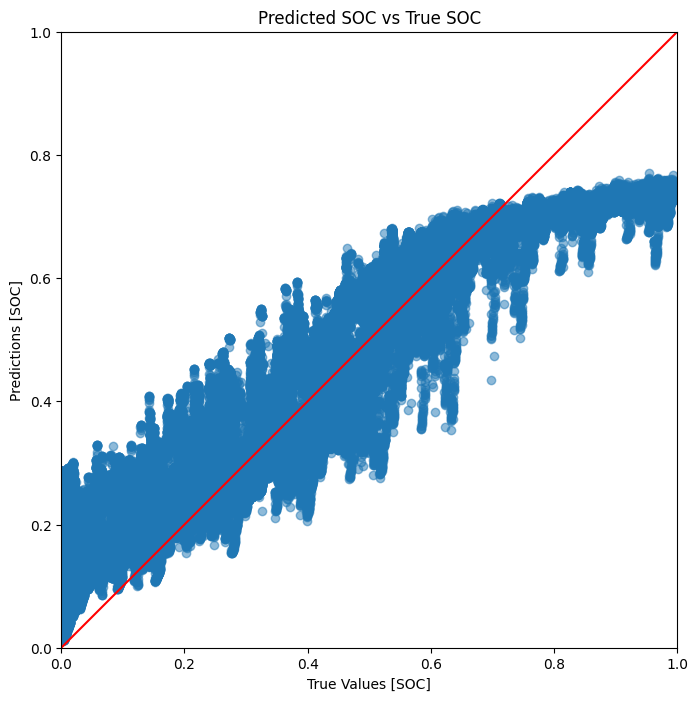

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

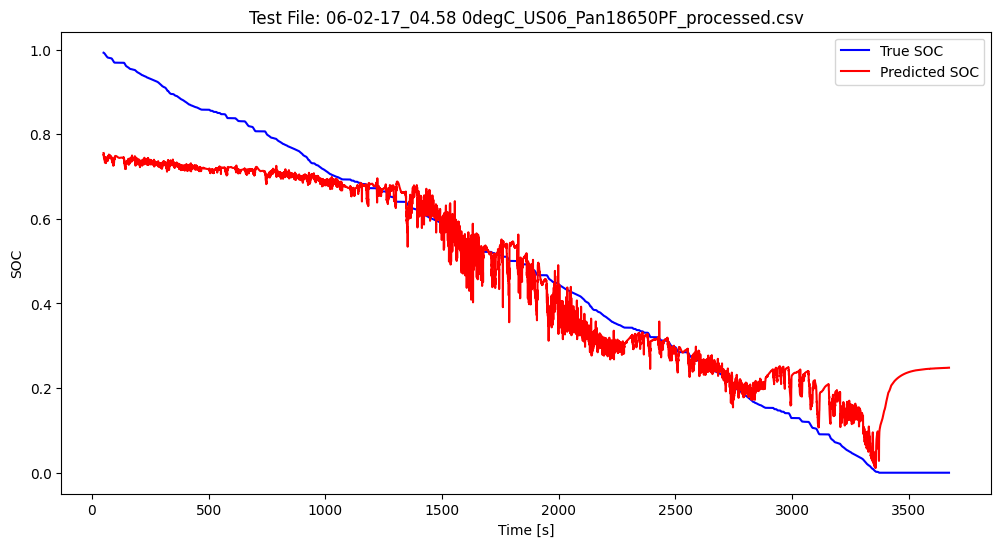

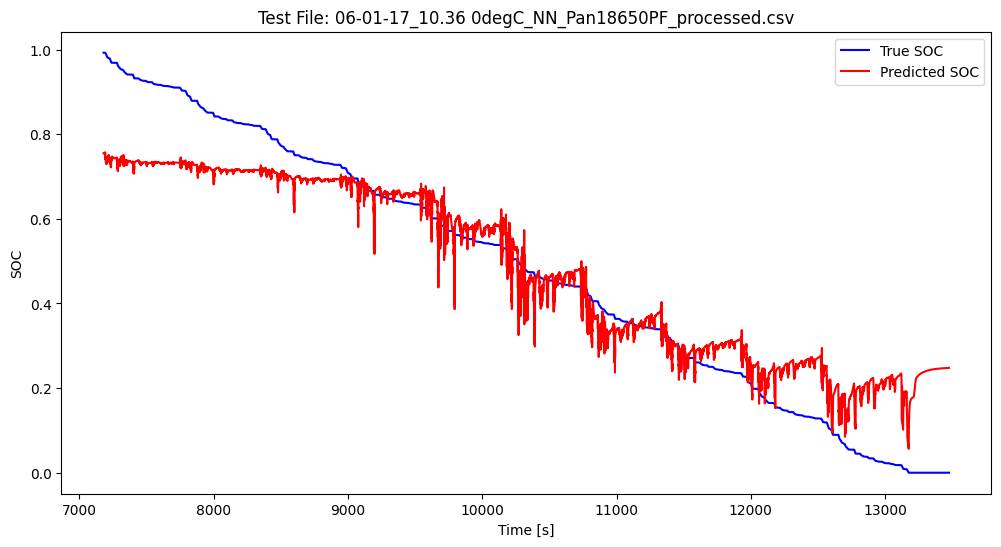

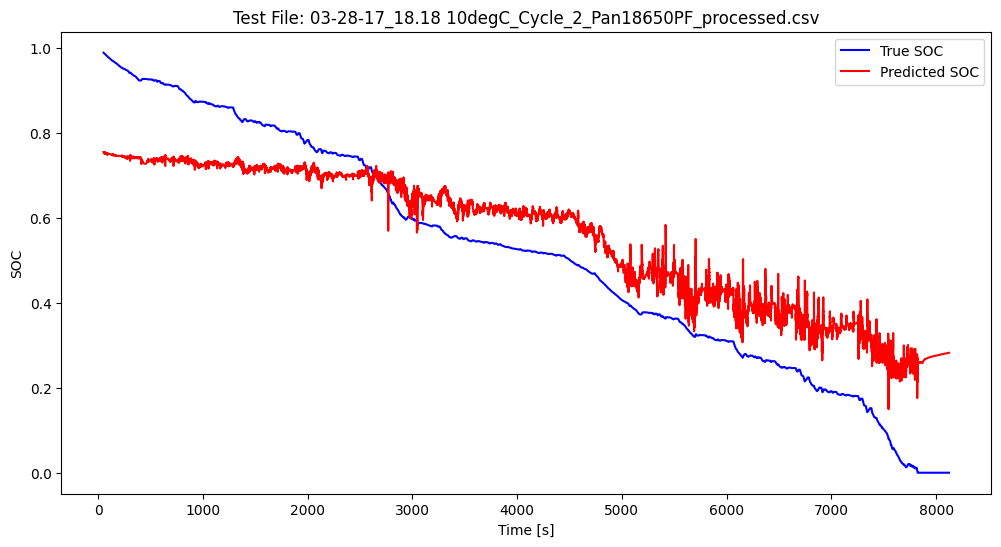

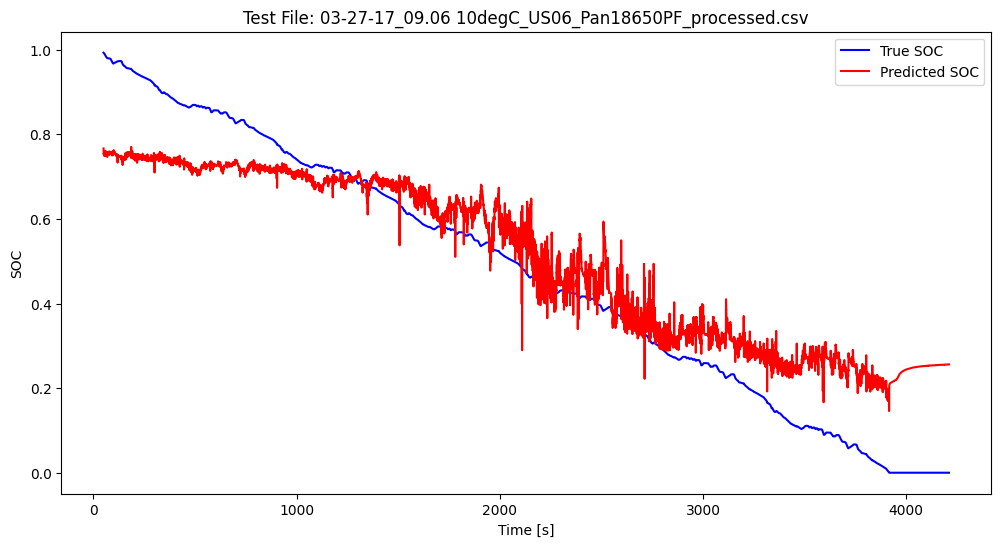

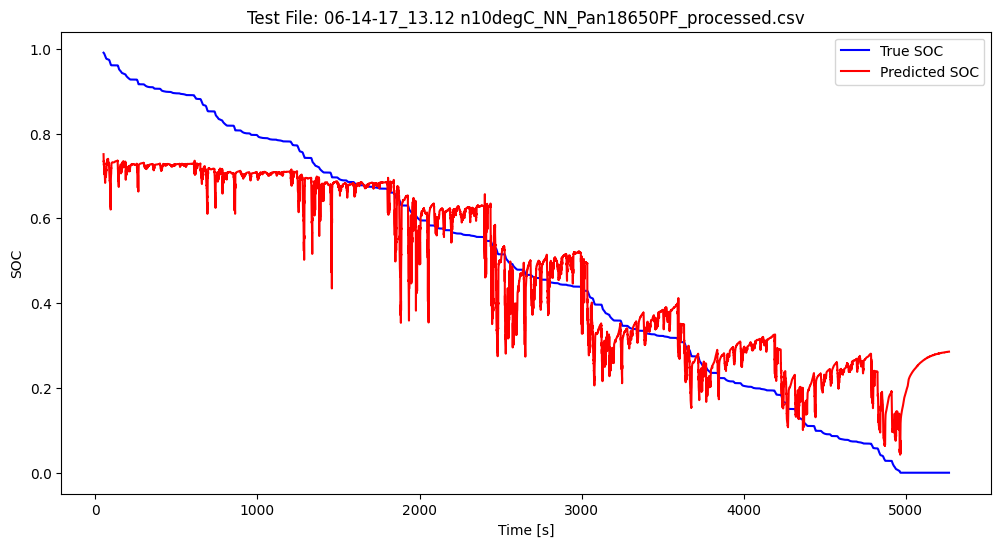

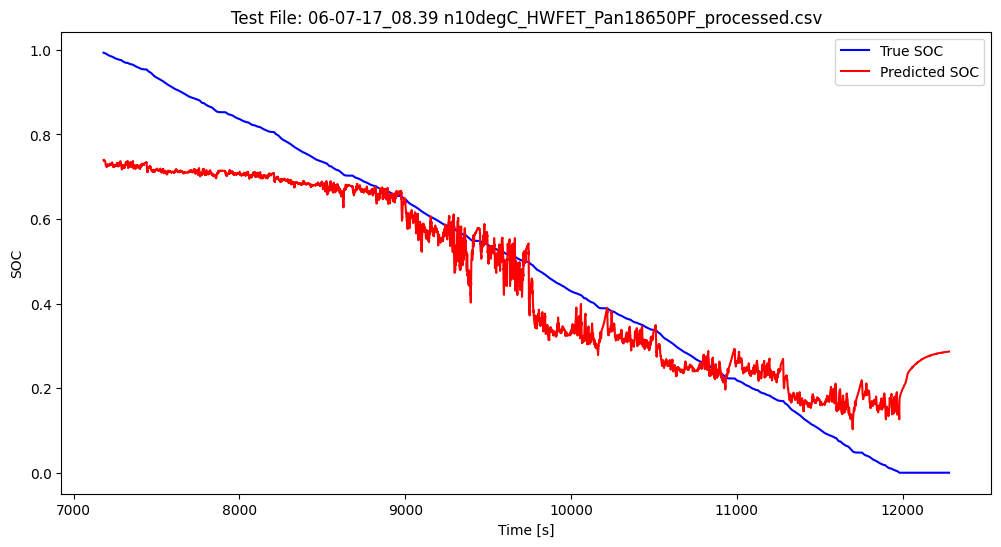

In [61]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)